# Noise Budgeting and Multi-Channel Correlation Analysis

In precision measurements (such as gravitational wave detectors), identifying the origin of noise contained in the main observation data is extremely important. This process is called **Noise Budgeting**.

The sensitivity curve of a gravitational wave detector is limited by ground vibrations at low frequencies, thermal noise at mid frequencies, and statistical noise (shot noise) at high frequencies, exhibiting a characteristic "U-shaped" profile.

In this tutorial, we will demonstrate the analysis with the following flow:

1.  **Multi-Channel Data Simulation**: In addition to the main channel, we generate auxiliary channels for ground vibrations, magnetic field fluctuations, circuit noise, etc.
2.  **Coherence Mapping**: Calculate the coherence between the main channel and each auxiliary channel to identify the primary noise sources.
3.  **Transfer Function Estimation**: Estimate the "coupling strength (transfer function)" from the auxiliary channels to the main channel.
4.  **Noise Projection**: Using the transfer function, convert (project) the noise from the auxiliary channels into the units of the main channel.
5.  **Noise Budget Visualization (Noise Budget Plot)**: Overlay all noise sources to reveal the breakdown of the observed "U-shaped" spectrum.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from gwexpy import TimeSeries, TimeSeriesDict
from gwexpy.noise.asd import from_pygwinc
from gwexpy.noise.wave import from_asd

## 1. Multi-Channel Data Simulation (Creating a U-Shaped Spectrum)

We create a sensitivity curve that mimics a gravitational wave detector.
*   `MAIN`: The observation target. Has a "U-shaped" spectrum dominated by ground vibrations in the low-frequency region and actuator/circuit system noise in the high-frequency region.
*   `AUX_SEIS`: Monitors low-frequency ground vibrations.
*   `AUX_MAG`: Magnetic field monitor (including 60Hz power line).
*   `AUX_ELEC`: High-frequency noise source (e.g., control system or readout circuit noise).

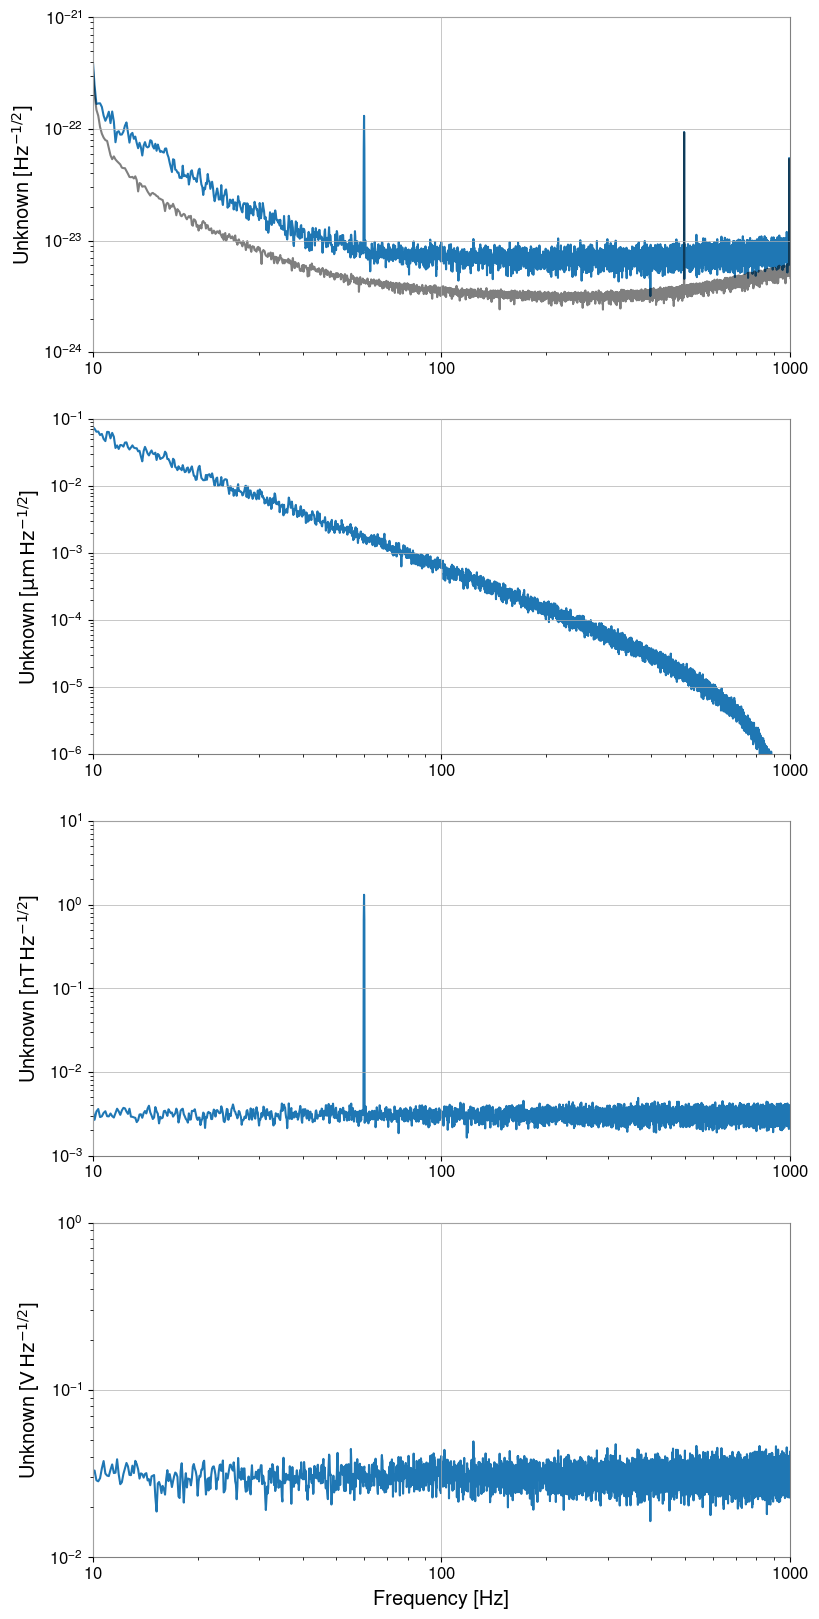

In [2]:
fs = 2048.0
duration = 64.0
t = np.arange(0, duration, 1 / fs)
n_samples = len(t)

np.random.seed(42)
rng = np.random.default_rng(42)

# Get aLIGO sensitivity curve (ASD) and use it as the reference noise for the main channel
fmax = fs / 2
asd_main = from_pygwinc(
    "aLIGO", fmin=5.0, fmax=fmax, df=1.0 / duration, quantity="strain"
)
main_base = from_asd(asd_main, duration, fs, t0=0, rng=rng).highpass(5)

# --- Generate Auxiliary Channels (Noise Sources) ---
# 1. Ground vibration (low-frequency dominance)
b_low, a_low = signal.butter(2, 2.0, fs=fs, btype="low")
seis_val = signal.lfilter(b_low, a_low, np.random.normal(0, 50.0, n_samples))
seis = TimeSeries(seis_val, sample_rate=fs, name="Seismic", unit="um")

# 2. Magnetic field (60Hz + flat)
mag_val = np.random.normal(0, 0.1, n_samples)
mag_val += 0.8 * np.sin(2 * np.pi * 60 * t)  # 60Hz
mag = TimeSeries(mag_val, sample_rate=fs, name="Magnetic", unit="nT")

# 3. High-frequency noise source (circuit system)
elec_val = np.random.normal(0, 1.0, n_samples)
elec = TimeSeries(elec_val, sample_rate=fs, name="Electronic", unit="V")

# --- Generate Main Channel  ---
main = (
    main_base
    + seis * (2e-21 * main_base.unit / seis.unit)
    + mag * (1e-22 * main_base.unit / mag.unit)
    + elec * (2e-22 * main_base.unit / elec.unit)
)


# Combine into dictionary
tsd = TimeSeriesDict()
tsd["MAIN"] = main
tsd["AUX_SEIS"] = seis
tsd["AUX_MAG"] = mag
tsd["AUX_ELEC"] = elec

# Check overall ASD
asd_dict = tsd.asd(fftlength=8, overlap=4, method="welch")
plot = asd_dict.plot(xscale="log", yscale="log", subplots=True, sharex=True)
axes = plot.get_axes()
axes[0].plot(
    main_base.asd(fftlength=8, overlap=4, method="welch"), alpha=0.5, color="black"
)
axes[0].set_xlim(10, 1000)
axes[0].set_ylim(1e-24, 1e-21)
axes[1].set_ylim(1e-6, 1e-1)
axes[2].set_ylim(1e-3, 1e1)
axes[3].set_ylim(1e-2, 1e0)
plt.show()

# You can see that the MAIN channel (expected to be black or blue) has a "U-shaped" profile,
# decreasing at low frequencies and increasing at high frequencies.


## 2. Coherence Mapping

We check which sensors have high coherence with the left side, bottom, and right side of the "U-shape" of the main channel.

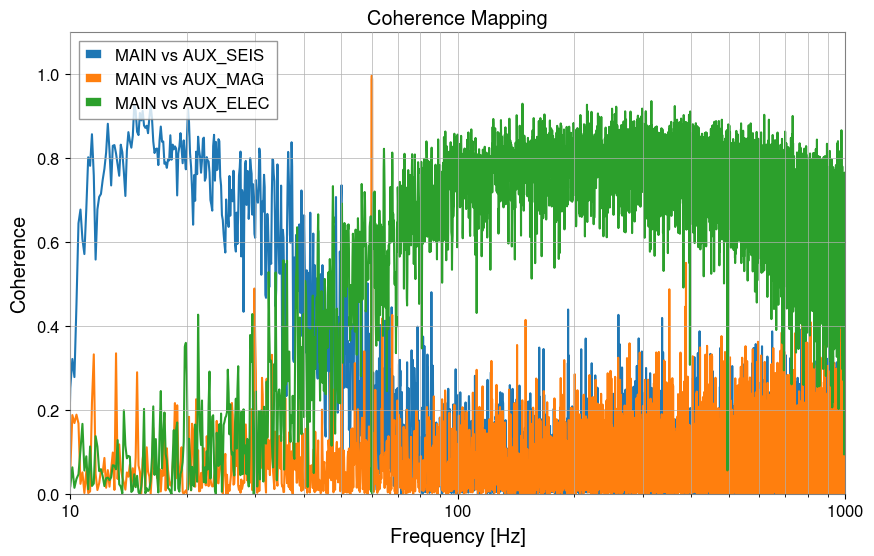

In [3]:
aux_names = ["AUX_SEIS", "AUX_MAG", "AUX_ELEC"]

plt.figure(figsize=(10, 6))
for name in aux_names:
    coh = tsd["MAIN"].coherence(tsd[name], fftlength=8)
    plt.semilogx(coh.frequencies, coh.value, label=f"MAIN vs {name}")

plt.title("Coherence Mapping")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Coherence")
plt.xlim(10, 1000)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, which="both")
plt.show()

# We can see that it correlates with SEIS at low frequencies (below 10Hz) and with ELEC at high frequencies (above 100Hz).

## 3. Transfer Function Estimation

We estimate the coupling coefficients (transfer functions) in each frequency band.

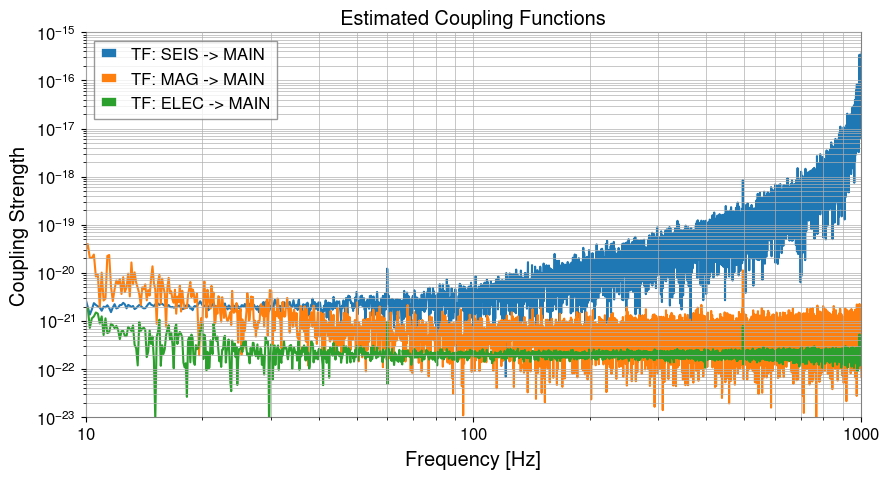

In [4]:
tf_seis = tsd["AUX_SEIS"].transfer_function(tsd["MAIN"], fftlength=8)
tf_mag = tsd["AUX_MAG"].transfer_function(tsd["MAIN"], fftlength=8)
tf_elec = tsd["AUX_ELEC"].transfer_function(tsd["MAIN"], fftlength=8)

plt.figure(figsize=(10, 5))
plt.loglog(tf_seis.abs(), label="TF: SEIS -> MAIN")
plt.loglog(tf_mag.abs(), label="TF: MAG -> MAIN")
plt.loglog(tf_elec.abs(), label="TF: ELEC -> MAIN")

plt.xlim(10, 1000)
plt.ylim(1e-23, 1e-15)
plt.title("Estimated Coupling Functions")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Coupling Strength")
plt.legend()
plt.grid(True, which="both")
plt.show()

## 4. Noise Projection

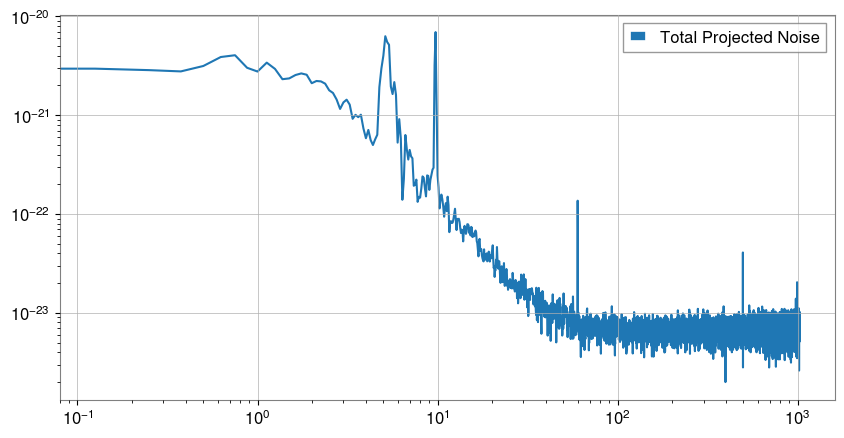

In [5]:
main_ch = tsd["MAIN"]
proj_seis = asd_dict["AUX_SEIS"] * tf_seis.abs()
proj_mag = asd_dict["AUX_MAG"] * tf_mag.abs()
proj_elec = asd_dict["AUX_ELEC"] * tf_elec.abs()

# Calculate total contribution as the square root of the sum of squares
total_proj = (proj_seis**2 + proj_mag**2 + proj_elec**2) ** 0.5

# Display total contribution in a graph
plt.figure(figsize=(10, 5))
plt.loglog(total_proj, label="Total Projected Noise")
plt.legend()
plt.show()

## 5. Noise Budget Visualization (Noise Budget Plot)

We display how the "U-shaped" noise of the main channel is explained and decomposed.

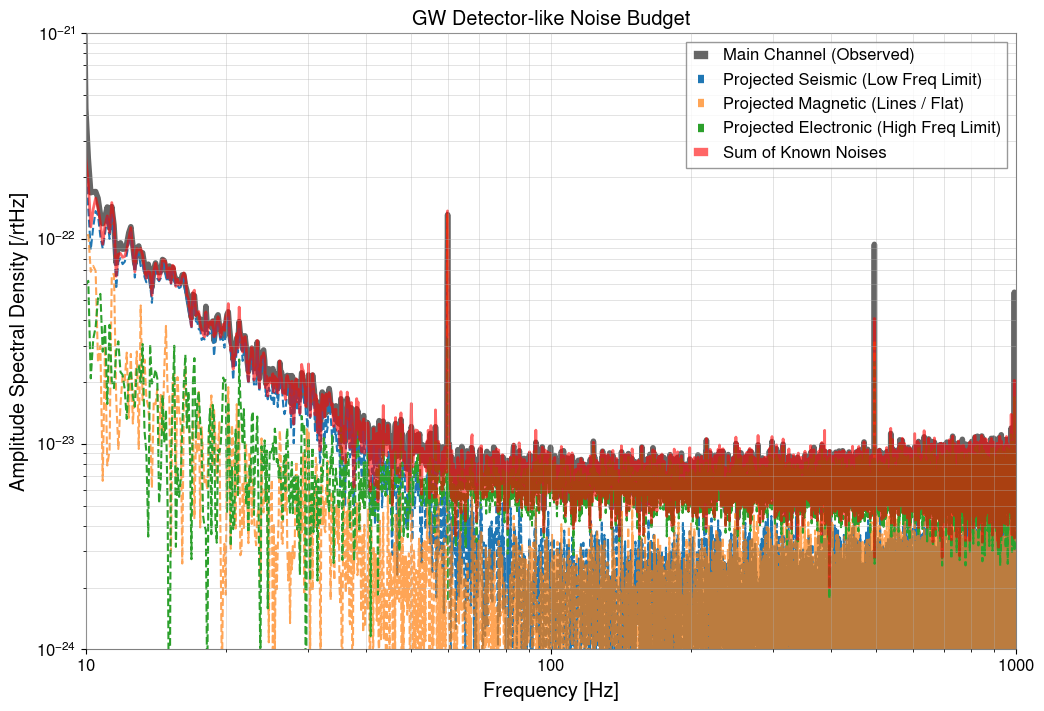

In [6]:
plt.figure(figsize=(12, 8))

# Actually observed sensitivity curve
plt.loglog(
    asd_dict["MAIN"],
    label="Main Channel (Observed)",
    color="black",
    linewidth=4,
    alpha=0.6,
)

# Each projected component
plt.loglog(proj_seis, label="Projected Seismic (Low Freq Limit)", ls="--")
plt.loglog(proj_mag, label="Projected Magnetic (Lines / Flat)", ls="--", alpha=0.7)
plt.loglog(proj_elec, label="Projected Electronic (High Freq Limit)", ls="--")

# Total projection
plt.loglog(total_proj, label="Sum of Known Noises", color="red", linewidth=2, alpha=0.6)

plt.title("GW Detector-like Noise Budget")
plt.xlabel("Frequency [Hz]")
plt.ylabel(f"Amplitude Spectral Density [{main_ch.unit}/rtHz]")
plt.xlim(10, 1000)
plt.ylim(1e-24, 1e-21)
plt.legend(frameon=True, facecolor="white", loc="upper right")
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

# In this way, we can see at a glance that the observed "U-shaped" sensitivity curve is formed by the combination of multiple noise sources.